# Model V1

In [1]:
import pathlib
import tensorflow as tf
import pandas as pd

from bcd.model.factory import ModelFactoryV1
from bcd.model.experiment import Experiment
from bcd.model.repo import ModelRepo
pd.set_option('display.max_rows',999)


## Configuration

In [2]:
# Experiment Parameters
%env "WANDB_NOTEBOOK_NAME" "01_model_V1.ipynb"
project = "BCD_V1"
full_dataset = False

# Model Parameters
force = False  # Whether to retrain if the model and weights already exist from a prior training session.
metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
loss = "binary_crossentropy"
activation = "sigmoid"
epochs = 100
learning_rate = 1e-4
num_classes = 2

# Dataset params
dataset = "CBIS-DDSM" if full_dataset else "CBIS-DDSM-10"
batch_size = 64 if full_dataset else 32
input_shape = (224,224,3)
output_shape = 1
train_dir = pathlib.Path("data/image/1_final/training/training/").with_suffix('') if full_dataset else pathlib.Path("data/image/1_final/training_10/training/").with_suffix('') 
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')

# Early stop parameters 
es_min_delta = 0.0001
es_monitor = "val_loss"  # Monitor validation loss for early stopping
es_patience = 8  # The number of epochs for which lack of improvement is tolerated 
es_restore_best_weights = True  # Returns the best weights rather than the weights at the last epoch.
es_verbose = 1

# Reduce LR on Plateau Parameters
rlr_monitor = "val_loss"
rlr_factor = 0.5
rlr_patience = 3
rlr_verbose = 1
rlr_mode = "auto"
rlr_min_delta = 1e-4
rlr_min_lr=1e-10



env: "WANDB_NOTEBOOK_NAME"="01_model_V1.ipynb"


## Experiment Config

In [3]:
config = {
    "project": project,        
    "dataset": dataset,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "epochs": epochs,    
    "learning_rate": learning_rate,
    "loss": loss,    
    "early_stop_min_delta": es_min_delta,
    "early_stop_monitor": es_monitor,
    "early_stop_patience": es_patience,
    "early_stop_restore_best_weights": es_restore_best_weights,
    "early_stop_verbose": es_verbose,
    "rlr_monitor": rlr_monitor,
    "rlr_factor": rlr_factor,
    "rlr_patience": rlr_patience,
    "rlr_verbose": rlr_verbose,
    "rlr_mode": rlr_mode,
    "rlr_min_delta": rlr_min_delta,
    "rlr_min_lr": rlr_min_lr
    
}

## Load Data

In [4]:
# Training DataSet (10%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True)

Found 276 files belonging to 2 classes.
Using 221 files for training.
Found 276 files belonging to 2 classes.
Using 55 files for validation.
Found 649 files belonging to 2 classes.


## Callbacks

In [5]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor=es_monitor, 
                                                       min_delta=es_min_delta,
                                                       patience=es_patience, 
                                                       restore_best_weights=es_restore_best_weights,
                                                       verbose=es_verbose)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor=rlr_monitor,
                                                          factor=rlr_factor,
                                                          patience=rlr_patience,
                                                          verbose=rlr_verbose,
                                                          mode=rlr_mode,
                                                          min_delta=rlr_min_delta,
                                                          min_lr=rlr_min_lr)
callbacks = [early_stop_callback, reduce_lr_callback]

## Dependencies

In [6]:
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
repo = ModelRepo()

## DenseNet Experiment

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                             

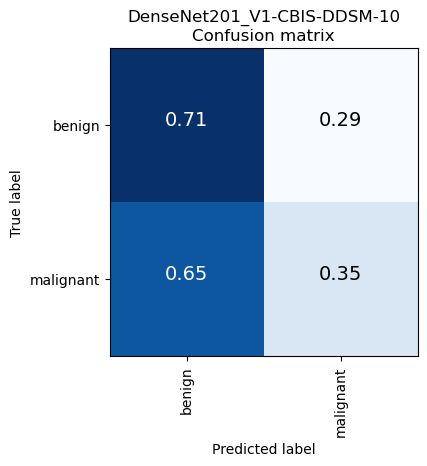

21/21 [==============================] - 115s 5s/step - loss: 0.6835 - accuracy: 0.5208 - auc: 0.5292 - precision: 0.3842 - recall: 0.2955


[0.6834872961044312,
 0.5208012461662292,
 0.5292453765869141,
 0.3842364549636841,
 0.2954545319080353]

In [7]:
# Obtain the DenseNet model
factory = ModelFactoryV1(input_shape=input_shape, output_shape=output_shape, activation=activation)
densenet = factory.create_densenet()
densenet.summary()

# Create and run the experiment.
densenet_experiment = Experiment(model=densenet, config=config, repo=repo, optimizer=optimizer, callbacks=callbacks, metrics=metrics, force=force)
densenet_experiment.run(train_ds=train_ds, val_ds=val_ds)
densenet_experiment.classification_report(data=val_ds)
densenet_experiment.plot_confusion_matrix(data=val_ds)
densenet_experiment.evaluate(data=test_ds)

## ResNet Experiment

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 resnet152v2 (Functional)    (None, None, None, 2048)  58331648  
                                                           

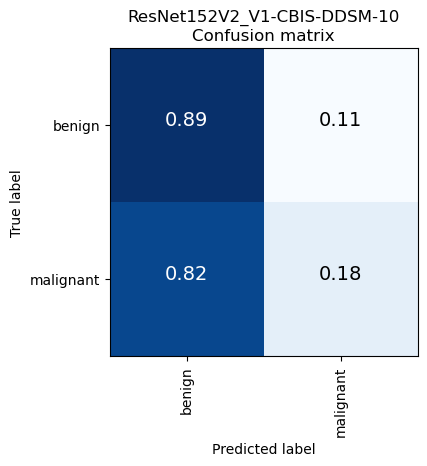

21/21 [==============================] - 150s 7s/step - loss: 0.6898 - accuracy: 0.5701 - auc: 0.5184 - precision: 0.4476 - recall: 0.2424


[0.6897546648979187,
 0.5701078772544861,
 0.5183687210083008,
 0.4475524425506592,
 0.24242424964904785]

In [8]:
# Obtain the ResNet model
resnet = factory.create_resnet()
resnet.summary()

# Create and run the experiment.
resnet_experiment = Experiment(model=resnet, config=config, repo=repo, optimizer=optimizer, callbacks=callbacks, metrics=metrics, force=force)
resnet_experiment.run(train_ds=train_ds, val_ds=val_ds)
resnet_experiment.classification_report(data=val_ds)
resnet_experiment.plot_confusion_matrix(data=val_ds)
resnet_experiment.evaluate(data=test_ds)

## Inception Experiment

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                           

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aistudio. Use `wandb login --relogin` to force relogin


Epoch 1/100
7/7 [==============================] - 27s 2s/step - loss: 0.7103 - accuracy: 0.5339 - auc: 0.4779 - precision: 0.3922 - recall: 0.2174 - val_loss: 0.6222 - val_accuracy: 0.6727 - val_auc: 0.6238 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - 18s 2s/step - loss: 0.6821 - accuracy: 0.5701 - auc: 0.5632 - precision: 0.4694 - recall: 0.2500 - val_loss: 0.6501 - val_accuracy: 0.6182 - val_auc: 0.5859 - val_precision: 0.3000 - val_recall: 0.1765 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - 18s 2s/step - loss: 0.6712 - accuracy: 0.5928 - auc: 0.5922 - precision: 0.5294 - recall: 0.1957 - val_loss: 0.6515 - val_accuracy: 0.6000 - val_auc: 0.6029 - val_precision: 0.3913 - val_recall: 0.5294 - lr: 1.0000e-04
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.5837 - auc: 0.6378 - precision: 0.5000 - recall: 0.5761
Epoch 4: ReduceLROnPlateau reducing le

wandb: Waiting for artifact InceptionV3_V1-CBIS-DDSM-10-wtu0w3od to be committed...



wandb: Committed artifact aistudio/BCD_V1/InceptionV3_V1-CBIS-DDSM-10-wtu0w3od:v0
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/accuracy,▁▃▄▄█▅█▅▄
epoch/auc,▁▄▅▇▆█▇▇▇
epoch/epoch,▁▂▃▄▅▅▆▇█
epoch/learning_rate,███▃▃▃▁▁▁
epoch/loss,█▅▄▄▄▁▁▁▂
epoch/lr,████▃▃▃▁▁
epoch/precision,▁▃▅▄█▆▇▅▄
epoch/recall,▁▂▁█▄▂▅▄▄
epoch/val_accuracy,█▆▅▃▄▃▁▂▃
epoch/val_auc,█▅▆▄▁▂▁▂▂
epoch/val_loss,▁▅▅▅▁▇█▇▇


              precision    recall  f1-score   support

      benign       0.69      0.97      0.80        38
   malignant       0.00      0.00      0.00        17

    accuracy                           0.67        55
   macro avg       0.34      0.49      0.40        55
weighted avg       0.47      0.67      0.56        55



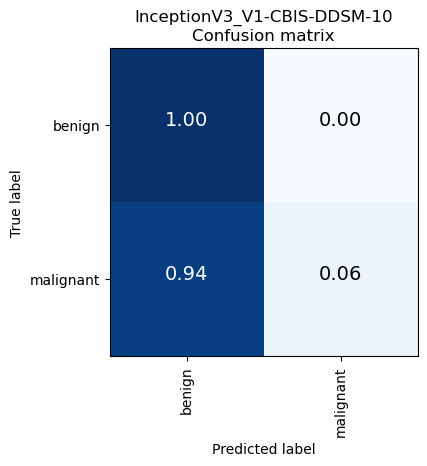

21/21 [==============================] - 43s 2s/step - loss: 0.6740 - accuracy: 0.5948 - auc: 0.5325 - precision: 0.6000 - recall: 0.0114


[0.6739670634269714,
 0.5947611927986145,
 0.5324872136116028,
 0.6000000238418579,
 0.011363636702299118]

In [9]:
# Obtain the ResNet model
inception = factory.create_inception()
inception.summary()

# Create and run the experiment.
inception_experiment = Experiment(model=inception, config=config, repo=repo, optimizer=optimizer, callbacks=callbacks, metrics=metrics, force=force)
inception_experiment.run(train_ds=train_ds, val_ds=val_ds)
inception_experiment.classification_report(data=val_ds)
inception_experiment.plot_confusion_matrix(data=val_ds)
inception_experiment.evaluate(data=test_ds)


## EfficientNet Experiment

In [10]:
# Obtain the Efficientnet model
efficientnet = factory.create_efficientnet()
efficientnet.summary()

# Create and run the experiment.
efficientnet_experiment = Experiment(model=efficientnet, config=config, repo=repo, optimizer=optimizer, callbacks=callbacks, metrics=metrics, force=force)
efficientnet_experiment.run(train_ds=train_ds, val_ds=val_ds)
efficientnet_experiment.classification_report(data=val_ds)
efficientnet_experiment.plot_confusion_matrix(data=val_ds)
efficientnet_experiment.evaluate(data=test_ds)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                          

Epoch 1/100
7/7 [==============================] - 46s 4s/step - loss: 0.7039 - accuracy: 0.4299 - auc: 0.5172 - precision: 0.3988 - recall: 0.1826 - val_loss: 0.6822 - val_accuracy: 0.6909 - val_auc: 0.3669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 2.5000e-05
Epoch 2/100
7/7 [==============================] - 27s 4s/step - loss: 0.6892 - accuracy: 0.5656 - auc: 0.4635 - precision: 0.4286 - recall: 0.1304 - val_loss: 0.6666 - val_accuracy: 0.6909 - val_auc: 0.4040 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 2.5000e-05
Epoch 3/100
7/7 [==============================] - 28s 4s/step - loss: 0.6823 - accuracy: 0.5882 - auc: 0.4962 - precision: 1.0000 - recall: 0.0109 - val_loss: 0.6545 - val_accuracy: 0.6909 - val_auc: 0.4389 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 2.5000e-05
Epoch 4/100
7/7 [==============================] - 29s 4s/step - loss: 0.6822 - accuracy: 0.5837 - auc: 0.4762 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss

ValueError: Unable to create dataset (name already exists)

In [ ]:
for i, w in enumerate(efficientnet.weights):
    print(i, w.name)

## Inception/Resnet Experiment

In [ ]:
# Obtain the Inception_resnet model
inception_resnet = factory.create_inception_resnet()
inception_resnet.summary()

# Create and run the experiment.
inception_resnet_experiment = Experiment(model=inception_resnet, config=config, repo=repo, optimizer=optimizer, callbacks=callbacks, metrics=metrics, force=force)
inception_resnet_experiment.run(train_ds=train_ds, val_ds=val_ds)
inception_resnet_experiment.classification_report(data=val_ds)
inception_resnet_experiment.plot_confusion_matrix(data=val_ds)
inception_resnet_experiment.evaluate(data=test_ds)


## MobileNet Experiment

In [ ]:
# Obtain the Mobilenet model
mobilenet = factory.create_mobilenet()
mobilenet.summary()

# Create and run the experiment.
mobilenet_experiment = Experiment(model=mobilenet, config=config, repo=repo, optimizer=optimizer, callbacks=callbacks, metrics=metrics, force=force)
mobilenet_experiment.run(train_ds=train_ds, val_ds=val_ds)
mobilenet_experiment.classification_report(data=val_ds)
mobilenet_experiment.plot_confusion_matrix(data=val_ds)
mobilenet_experiment.evaluate(data=test_ds)


## Xception Experiment

In [ ]:
# Obtain the Xception model
xception = factory.create_xception()
xception.summary()

# Create and run the experiment.
xception_experiment = Experiment(model=xception, config=config, repo=repo, optimizer=optimizer, callbacks=callbacks, metrics=metrics, force=force)
xception_experiment.run(train_ds=train_ds, val_ds=val_ds)
xception_experiment.classification_report(data=val_ds)
xception_experiment.plot_confusion_matrix(data=val_ds)
xception_experiment.evaluate(data=test_ds)
